# Predição da Nota do Enem 2016
**Por**: Kaike Wesley Reis

## Módulos

In [1]:
# Misc
import warnings

# Manipulação de Dados
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Análise de dados faltantes
import missingno as msno

# Pré-processamento
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression

# Comandos do notebook
warnings.filterwarnings('ignore')
%matplotlib inline

# Pré-processamento

## Importação dos dados

In [30]:
# Importação
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv')

## Emparelhamento das colunas dos datasets (treino e teste)

In [31]:
cols = ['NU_NOTA_MT'] + list(test.columns)
train = train[cols]

## Criar coluna para predição no conjunto de teste

In [32]:
test['NU_NOTA_MT'] = np.nan

## Inserir zero automaticamente no conjunto de teste para pessoas que faltaram a prova de Linguagem e Códigos (mesmo dia de matemática)

In [33]:
for i in range(0, len(test)):
    if test.loc[i, 'TP_PRESENCA_LC'] == 0:
        test.loc[i, 'NU_NOTA_MT'] = 0

## Eliminação de amostras do conjunto de treinamento - CRITÉRIO QUALITATIVO

### (1) Quem ficou ausente no segundo dia será retirado do conjunto de treinamento (não contribui para as notas de matemática)

In [34]:
# Tamanho atual de amostras no conjunto de treinamento
len(train)

13730

In [35]:
# Quantidade de amostras que seguem esse padrao para eliminacao
len(train[train['TP_PRESENCA_LC'] == 0])

3592

In [36]:
# Remover amostras que seguem padrao (1)
train = train[train['TP_PRESENCA_LC'] != 0]

In [37]:
# Resetar index
train.index = range(0, len(train))

### (2) Quem tomou zero ou tem a nota faltante em matemática provavelmente nem fez a prova

In [38]:
# Tamanho atual de amostras no conjunto de treinamento
len(train)

10138

In [39]:
# Quantidade de amostras que seguem esse padrao - resultado zero na prova
len(train[train['NU_NOTA_MT'] == 0])

10

In [40]:
# Quantidade de amostras que seguem esse padrao - valor faltante em matemática
sum(pd.isnull(train['NU_NOTA_MT']))

5

In [41]:
# Remover amostras que seguem padrao (2) - resultado zero na prova
train = train[train['NU_NOTA_MT'] != 0]
# Tamanho atual de amostras no conjunto de treinamento
len(train)

10128

In [42]:
# Remover amostras que seguem padrao (2) - resultado zero na prova
train = train[pd.notnull(train['NU_NOTA_MT'])]
# Tamanho atual de amostras no conjunto de treinamento
len(train)

10123

### (3) Colunas irrelevantes até o momento para o conjunto de treinamento e teste

In [43]:
# Colunas para limpar
cols_to_remove = ['SG_UF_RESIDENCIA','CO_UF_RESIDENCIA','TP_ANO_CONCLUIU','TP_DEPENDENCIA_ADM_ESC',
                  'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT','TP_LINGUA',
                  'TP_STATUS_REDACAO','TP_PRESENCA_CN','NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                  'NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5']

In [44]:
# Remoção
train.drop(axis=1, columns=cols_to_remove, inplace=True)
test.drop(axis=1, columns=cols_to_remove, inplace=True)

### (4) Colunas que **não** servem como features para o modelo no conjunto de treinamento

In [45]:
# Colunas para limpar
cols_to_remove = ['NU_INSCRICAO']
# Remoção
train.drop(axis=1, columns=cols_to_remove, inplace=True)

## Lidando com valores faltantes - Conjunto de treinamento

### Matriz de Missing

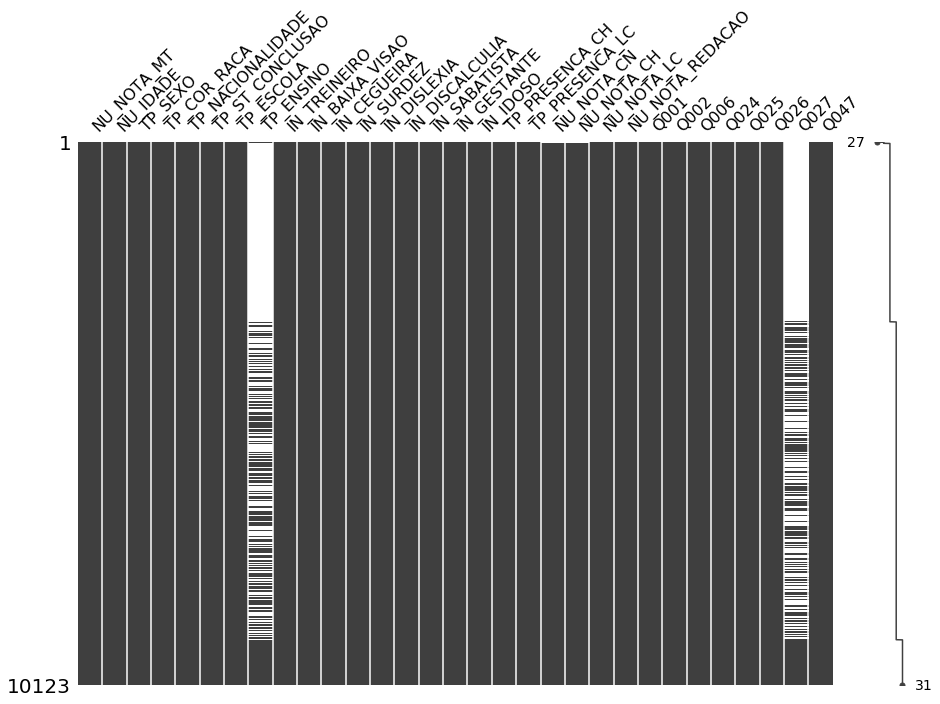

In [46]:
# Nullity Matrix para conjunto de treinamento
msno.matrix(train, sort='ascending', figsize=(15, 10));

In [47]:
# Colunas muito faltantes para remover
cols_to_remove = ['TP_ENSINO', 'Q027']

São colunas importantes?

`TP_ENSINO` - Tipo de instituição que concluiu ou concluirá o Ensino Médio. Essa coluna é redundante com `TP_ESCOLA`.

`Q027` - Com que idade você começou a exercer uma atividade remunerada. Num contexto socioeconomico é importante. Seu missing é enviesado.

In [48]:
# Remover colunas muito faltantes
train.drop(axis=1, inplace=True, columns=cols_to_remove)
test.drop(axis=1, inplace=True, columns=cols_to_remove)

### Matriz de Missing x2

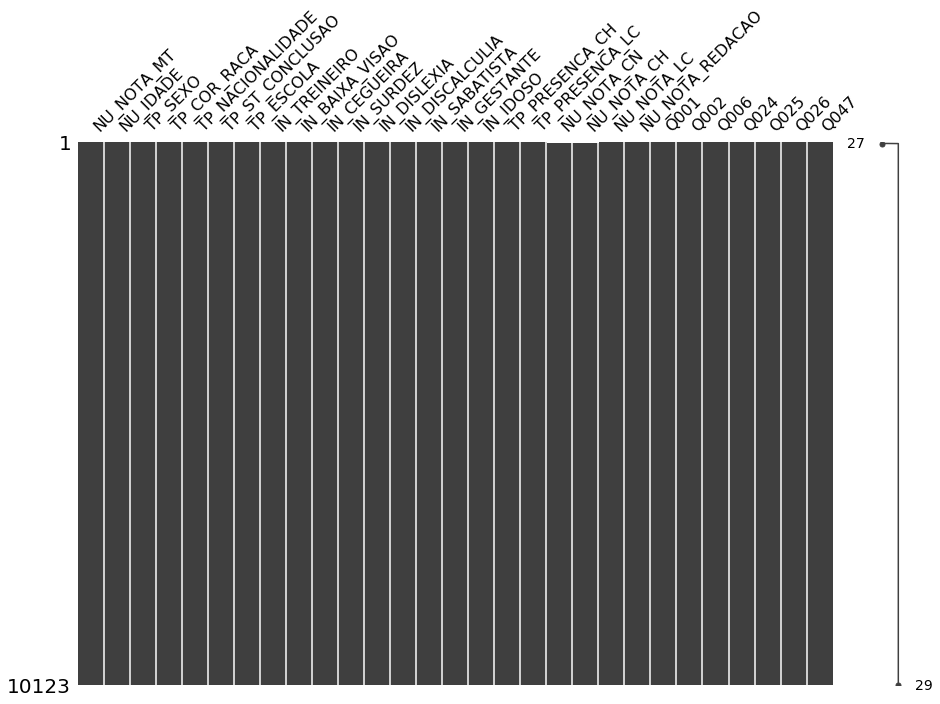

In [49]:
# Matriz de missing em treinamento novamente
msno.matrix(train, sort='ascending', figsize=(15, 10));

A alterada de 29 para 27 mostra que tem duas colunas com valores faltantes

In [50]:
# Quais colunas estão com alguma amostra faltante ainda?
pd.isnull(train).sum()

NU_NOTA_MT           0
NU_IDADE             0
TP_SEXO              0
TP_COR_RACA          0
TP_NACIONALIDADE     0
TP_ST_CONCLUSAO      0
TP_ESCOLA            0
IN_TREINEIRO         0
IN_BAIXA_VISAO       0
IN_CEGUEIRA          0
IN_SURDEZ            0
IN_DISLEXIA          0
IN_DISCALCULIA       0
IN_SABATISTA         0
IN_GESTANTE          0
IN_IDOSO             0
TP_PRESENCA_CH       0
TP_PRESENCA_LC       0
NU_NOTA_CN          35
NU_NOTA_CH          35
NU_NOTA_LC           0
NU_NOTA_REDACAO      0
Q001                 0
Q002                 0
Q006                 0
Q024                 0
Q025                 0
Q026                 0
Q047                 0
dtype: int64

Aparentemente temos 35 amostras faltantes em duas colunas de notas. Vamos olhar mais de perto essas amostras considerando a coluna `TP_PRESENCA_CH` o que pode indicar o porque dessa ausencia no primeiro dia:

In [51]:
# Index para essas situações faltantes na nota de CN
train[pd.isnull(train['NU_NOTA_CN'])].index

Int64Index([ 737, 1215, 1317, 1320, 1347, 2034, 2170, 2794, 3100, 3196, 3775,
            3934, 4273, 4472, 4718, 5144, 5263, 5368, 5659, 5720, 5747, 5859,
            5967, 6095, 6636, 7004, 7011, 7998, 8362, 8998, 9297, 9310, 9325,
            9743, 9832],
           dtype='int64')

In [52]:
# Index para essas situacoes faltantes na nota de CH
train[pd.isnull(train['NU_NOTA_CH'])].index

Int64Index([ 737, 1215, 1317, 1320, 1347, 2034, 2170, 2794, 3100, 3196, 3775,
            3934, 4273, 4472, 4718, 5144, 5263, 5368, 5659, 5720, 5747, 5859,
            5967, 6095, 6636, 7004, 7011, 7998, 8362, 8998, 9297, 9310, 9325,
            9743, 9832],
           dtype='int64')

Essas amostras faltantes em ambas as colunas são nos mesmo **indexes**. Como está as colunas de presença?

In [53]:
train[pd.isnull(train['NU_NOTA_CN']) & pd.isnull(train['NU_NOTA_CH'])][['TP_PRESENCA_CH']]

,TP_PRESENCA_CH
737,0
1215,0
1317,0
1320,0
1347,0
2034,0
2170,0
2794,0
3100,0
3196,0


O valor `0` e `2` indicam respectivamente que o aluno estava ausente ou foi desclassificado de alguma forma, logo esses valores faltantes são zero. Considerando que estamos no conjunto de treino podemos sim fazer a eliminação dessas amostras. Vamos continuar a análise agora avaliando como está a coluna de notas:

In [54]:
train[pd.isnull(train['NU_NOTA_CN']) & pd.isnull(train['NU_NOTA_CH'])][['NU_NOTA_MT']]

,NU_NOTA_MT
737,445.4
1215,397.6
1317,466.8
1320,329.0
1347,381.1
2034,454.5
2170,472.6
2794,461.2
3100,409.3
3196,453.6


Existem valores realmente, todavia vou optar por **descartar essas amostras ao invés de fazer imputação**, visto que as notas são relativamente baixas e essa quantidade de amostra representa apenas 0.3%. Provavelmente esses alunos faltaram no primeiro dia por razões maiores e no segundo não tiveram bons resultados, pois sabiam que havia perdido.

In [55]:
# Removendo colunas
train = train[pd.notnull(train['NU_NOTA_CN']) & pd.notnull(train['NU_NOTA_CH'])]

# Resetar index
train.index = range(0, len(train))

### Matriz de Missing x3

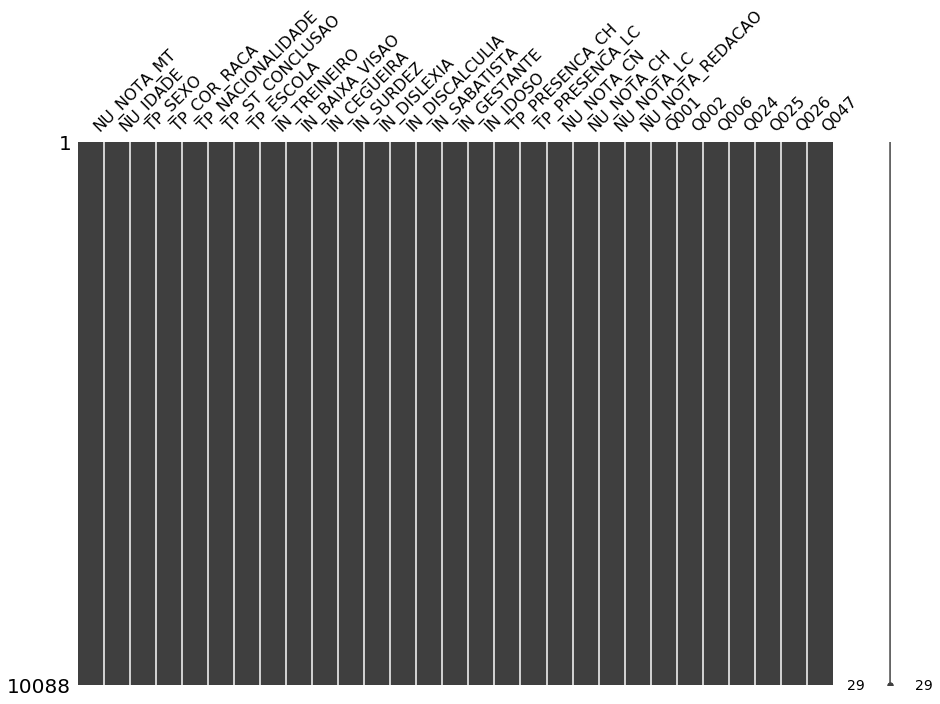

In [56]:
# Matriz de missing em treinamento novamente
msno.matrix(train, sort='ascending', figsize=(15, 10));

Nenhum valor faltante no conjunto de treinamento. Para verificar com certeza:

In [57]:
# Somar todos os missing por coluna e então somar geral
sum(pd.isnull(train).sum())

0

Ao final, cerca de **27%** de amostras ruidosas foram removidas do nosso banco de dados. Isso mostra a importância de uma análise criteriosa no conjunto antes da criação de qualquer modelo.

## Removendo colunas do conjunto de treinamento que não serão usadas como features
As colunas `'TP_PRESENCA_CH'` e `'TP_PRESENCA_LC'` ajudam bastante na análise de missing, mas sua existência como features é irrelevante, pois as notas já suprem isso.

In [58]:
train.drop(axis=1, inplace=True, columns=['TP_PRESENCA_CH','TP_PRESENCA_LC'])

In [59]:
# Verificando colunas finais
train.columns

Index(['NU_NOTA_MT', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'IN_TREINEIRO', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q047'],
      dtype='object')

## Lidando com valores faltantes - Conjunto de treinamento

### Matriz de Missing

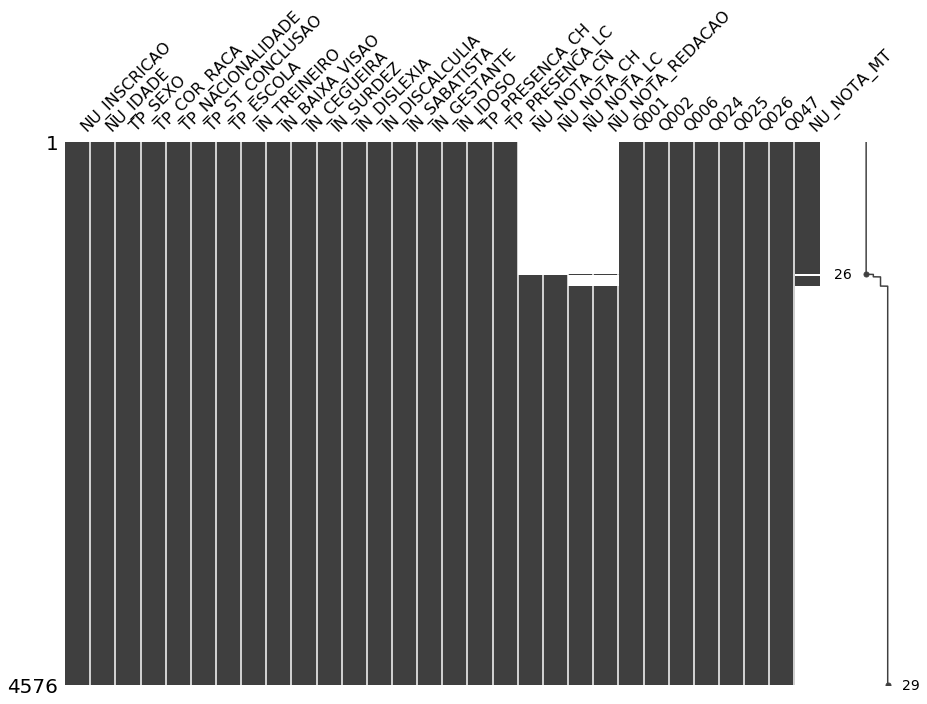

In [60]:
# Matriz de missing em teste
msno.matrix(test, sort='ascending', figsize=(15, 10));

Aparentemente existem valores ausentes nas colunas de notas e eles estão muito atrelados com os alunos que **zeraram** matemática. Como o desafio pede a predição de todas notas, irei fazer a imputação dos valores faltantes das notas seguindo a seguinte prerrogativa:

- (1) Considerando `TP_PRESENCA_CH` como a presença no primeiro dia. Caso seu valor seja `0` isso implica automaticamente em zero nas provas: `NU_NOTA_CN`, `NU_NOTA_CH`
- (2) Considerando `TP_PRESENCA_LC` como a presença no segundo dia. Caso seu valor seja `0` isso implica automaticamente em zero nas provas: `NU_NOTA_LC`, `NU_NOTA_REDACAO` (Note que `NU_NOTA_MT` já foi feito lá em cima)
- (3) Considerando `TP_PRESENCA_CH` com valor igual a `2` (desclassificado na prova) isso implica automaticamente em zero nas prova: `NU_NOTA_CH`
- (4) Considerando `TP_PRESENCA_LC` com valor igual a `2` (desclassificado na prova) isso implica automaticamente em zero nas prova: `NU_NOTA_LC`

Isso será feito de modo manual para deixar mais claro o raciocinio:

In [61]:
# (1) & (3)
for i in range(0, len(test)):
    if test.loc[i, 'TP_PRESENCA_CH'] == 0:
        if pd.isnull(test.loc[i, 'NU_NOTA_CN']):
            test.loc[i, 'NU_NOTA_CN'] = 0
        if pd.isnull(test.loc[i, 'NU_NOTA_CH']):
            test.loc[i, 'NU_NOTA_CH'] = 0
    elif test.loc[i, 'TP_PRESENCA_CH'] == 2:
        if pd.isnull(test.loc[i, 'NU_NOTA_CH']):
            test.loc[i, 'NU_NOTA_CH'] = 0

In [62]:
# (2) & (4)
for i in range(0, len(test)):
    if test.loc[i, 'TP_PRESENCA_LC'] == 0:
        if pd.isnull(test.loc[i, 'NU_NOTA_LC']):
            test.loc[i, 'NU_NOTA_LC'] = 0
        if pd.isnull(test.loc[i, 'NU_NOTA_REDACAO']):
            test.loc[i, 'NU_NOTA_REDACAO'] = 0

    elif test.loc[i, 'TP_PRESENCA_LC'] == 2:
        if pd.isnull(test.loc[i, 'NU_NOTA_LC']):
            test.loc[i, 'NU_NOTA_LC'] = 0

#### (!!!)
**OBS**: Remover a verificação de ser NaN pode ser interessante para dar veracidade, visto que se a presença tem aqueles valores mesmo que exista alguma nota, ela não é real!

### Matriz de Missing x2

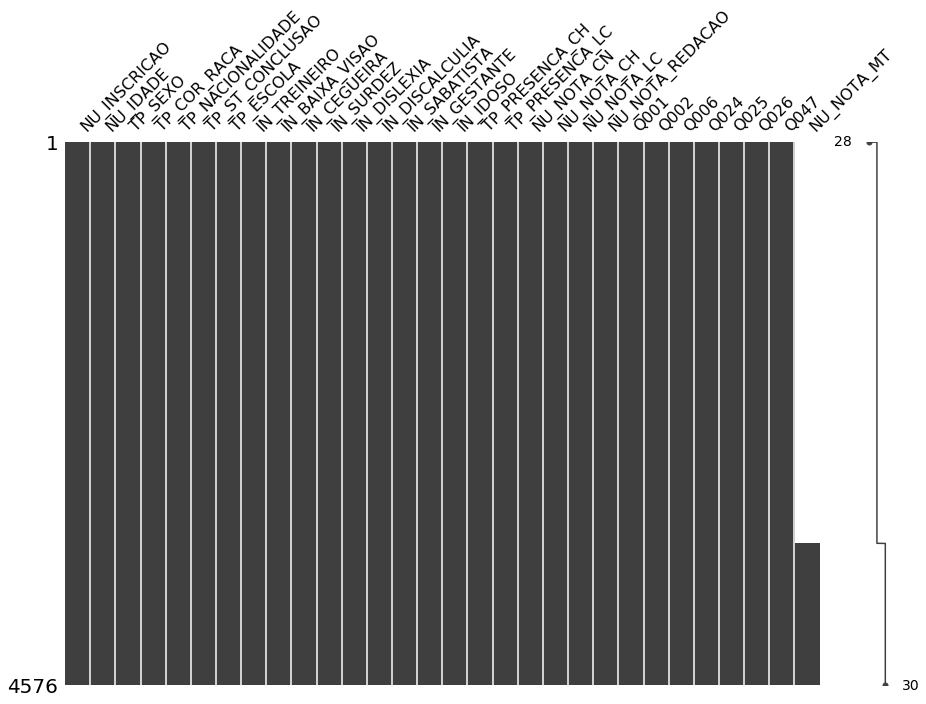

In [63]:
# Matriz de missing em teste
msno.matrix(test, sort='ascending', figsize=(15, 10));

Com as colunas `TP_PRESENCA` foi possivel rapidamente eliminar nossos missing values! Todavia, a transição de 30 para 28 mostra que pelo menos uma coluna possui algum valor faltante (`NU_NOTA_MT`) já era esperado.

In [64]:
# Quais colunas estão com alguma amostra faltante ainda?
pd.isnull(test).sum()

NU_INSCRICAO           0
NU_IDADE               0
TP_SEXO                0
TP_COR_RACA            0
TP_NACIONALIDADE       0
TP_ST_CONCLUSAO        0
TP_ESCOLA              0
IN_TREINEIRO           0
IN_BAIXA_VISAO         0
IN_CEGUEIRA            0
IN_SURDEZ              0
IN_DISLEXIA            0
IN_DISCALCULIA         0
IN_SABATISTA           0
IN_GESTANTE            0
IN_IDOSO               0
TP_PRESENCA_CH         0
TP_PRESENCA_LC         0
NU_NOTA_CN             0
NU_NOTA_CH             0
NU_NOTA_LC             0
NU_NOTA_REDACAO        4
Q001                   0
Q002                   0
Q006                   0
Q024                   0
Q025                   0
Q026                   0
Q047                   0
NU_NOTA_MT          3381
dtype: int64

In [65]:
# Vamos ver mais a fundo essas amostras
test[pd.isnull(test['NU_NOTA_REDACAO'])][['TP_PRESENCA_LC','NU_NOTA_MT','NU_NOTA_LC','NU_NOTA_REDACAO',
                                          'TP_PRESENCA_CH','NU_NOTA_CH','NU_NOTA_CN']]

,TP_PRESENCA_LC,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,TP_PRESENCA_CH,NU_NOTA_CH,NU_NOTA_CN
1239,2,NaN,0.0,NaN,1,562.7,393.7
2302,2,NaN,0.0,NaN,1,576.6,509.0
2593,2,NaN,0.0,NaN,1,568.2,561.1
3875,2,NaN,0.0,NaN,1,610.2,429.9


Aparentemente esses alunos participaram no segundo dia, mas no segundo foram reprovados de alguma forma. Provavelmente foram desclassificados no geral (pegos pescando por exemplo). Avaliando o número de pessoas com valor 2 na coluna `TP_PRESENCA_LC`:

In [66]:
test[test['TP_PRESENCA_LC'] == 2].index

Int64Index([1239, 2302, 2593, 3875], dtype='int64')

Vemos que só existem esses 4 desclassificados e que são os mostrados anteriormente. Com essas evidências irei assumir que tanto `NU_NOTA_REDACAO` e `NU_NOTA_MT` apresentam o valor `0`, pois tudo indica que essas pessoas não fizeram esse dia 2 corretamente (expulsos).

In [67]:
for i in test[test['TP_PRESENCA_LC'] == 2].index:
    test.loc[i, 'NU_NOTA_MT'] = 0
    test.loc[i, 'NU_NOTA_REDACAO'] = 0

In [68]:
# Vamos ver o resultado final
test.loc[[1239,2302,2593,3875], ['TP_PRESENCA_LC','NU_NOTA_MT','NU_NOTA_LC','NU_NOTA_REDACAO','TP_PRESENCA_CH','NU_NOTA_CH',
                                 'NU_NOTA_CN']]

,TP_PRESENCA_LC,NU_NOTA_MT,NU_NOTA_LC,NU_NOTA_REDACAO,TP_PRESENCA_CH,NU_NOTA_CH,NU_NOTA_CN
1239,2,0.0,0.0,0.0,1,562.7,393.7
2302,2,0.0,0.0,0.0,1,576.6,509.0
2593,2,0.0,0.0,0.0,1,568.2,561.1
3875,2,0.0,0.0,0.0,1,610.2,429.9


### Matriz de Missing x3

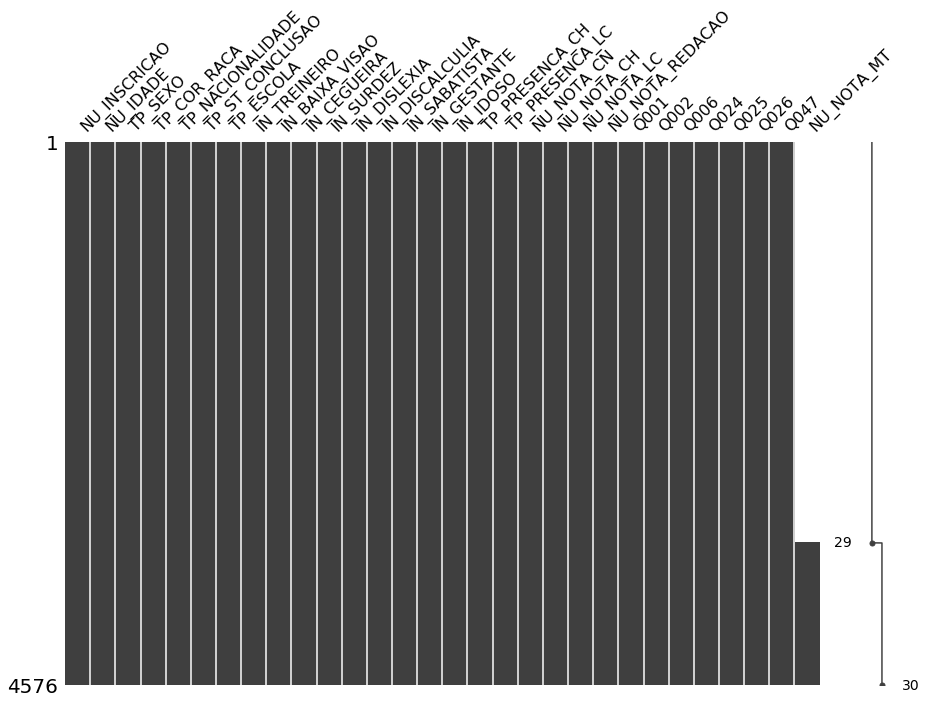

In [69]:
# Matriz de missing em teste
msno.matrix(test, sort='ascending', figsize=(15, 10));

Agora apenas os valores faltantes estão na coluna do nosso objetivo. De quebra ainda conseguimos prever, sem modelo, os valores de mais 4 notas

## Removendo colunas do conjunto de teste que não serão usadas como features para o modelo
As colunas `'TP_PRESENCA_CH'` e `'TP_PRESENCA_LC'` ajudaram bastante na análise de missing, mas sua existência como features é irrelevante, pois as notas já suprem isso e os missing já foram eliminados.

In [70]:
test.drop(axis=1, inplace=True, columns=['TP_PRESENCA_CH','TP_PRESENCA_LC'])

## Overview geral na quantidade de colunas por dataset

In [71]:
len(train.columns)

27

In [72]:
len(test.columns)

28

A diferença reside no `NU_INCRICAO` necessário para a conclusão do envio da resposta do desafio.

# Transformação das variáveis categóricas
Torna-las legíveis para o modelo e análise de features.

## Definição do conjunto de variáveis categóricas em
- Ordinal (Label Encoding)
- Nominal (One Hot Encoding)
- Binária (Apenas inserir zero e um)

In [73]:
# Divisão - X (ordinal)
feat_ord = ['Q001','Q002','Q006','Q024','Q026']
# Divisão - X (nominal)
feat_non = ['TP_COR_RACA','TP_NACIONALIDADE','TP_ST_CONCLUSAO','TP_ESCOLA','Q047']
# Divisão - X (binário)
feat_bin = ['TP_SEXO','IN_TREINEIRO','IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DISLEXIA',
            'IN_DISCALCULIA','IN_SABATISTA','IN_GESTANTE','IN_IDOSO','Q025']

### FUNCÃO - Transformação Binária & Dummies

In [74]:
def transformarCategoricosBinariosNominais(df):
    # BINARIO
    for i in range(0, len(df)):
        ## 'TP_SEXO'
        val = df.loc[i,'TP_SEXO']
        if val == 'M':
            df.loc[i,'TP_SEXO'] = 1
        elif val == 'F':
            df.loc[i,'TP_SEXO'] = 0
        
        ## 'Q025'
        val = df.loc[i,'Q025']
        if val == 'A': #NAO
            df.loc[i,'Q025'] = 0
        elif val == 'B':#SIM
            df.loc[i,'Q025'] = 1        
        
        ## 'IN_TREINEIRO'
        ## 'IN_BAIXA_VISAO'
        ## 'IN_CEGUEIRA'
        ## 'IN_SURDEZ'
        ## 'IN_DISLEXIA'
        ## 'IN_DISCALCULIA'
        ## 'IN_SABATISTA'
        ## 'IN_GESTANTE'
        ## 'IN_IDOSO' 
        ## Já são numericos
    
    # Nominal para Dummies
    ## Mudar o tipo de int para str para fazer as dummies corretamente em todas exceto 'Q047' (já é do tipo str)
    for i in range(0, len(df)):
        for j in ['TP_COR_RACA','TP_NACIONALIDADE','TP_ST_CONCLUSAO','TP_ESCOLA']:
            df.loc[i, j] = str(df.loc[i, j])
    ## Dummify!
    for j in ['TP_COR_RACA','TP_NACIONALIDADE','TP_ST_CONCLUSAO','TP_ESCOLA','Q047']:
        # Criar as dummies
        dummies = pd.get_dummies(df[j], prefix=j)
        # Concatenar no original
        df = pd.concat([df, dummies],axis=1)
        # Remover coluna original
        df.drop(axis=1, inplace=True, columns=[j])
    ## Finish
    return df

### Aplicação - Transformação Binária & Dummies

In [75]:
# Processo - Treinamento
trainset = transformarCategoricosBinariosNominais(train)

In [76]:
# Processo - Teste
testset = transformarCategoricosBinariosNominais(test)

### FUNCÃO - Transformação Ordinal

In [77]:
def transformarCategoricosOrdinais(df_train, df_test):
    for j in feat_ord:
        enc = OrdinalEncoder()
        X = np.array(df_train[j]).reshape(-1,1)
        XS = enc.fit_transform(X)
        df_train[j] = XS
        X = np.array(df_test[j]).reshape(-1,1)
        XS = enc.transform(X)
        df_test[j] = XS
    return df_train, df_test

### Aplicação - Transformação Ordinal

In [78]:
# Processo - Treinamento e Teste
trainset, testset = transformarCategoricosOrdinais(trainset, testset)

#### (!!!)
**OBS 2**: Note que talvez seja importante utilizar o OneHot Encoding na transformação anterior a Ordinal para evitar classes erradas ou sumiço delas.

### Avaliar se tem alguma coluna sem variação

In [79]:
for j in trainset.columns:
    if not j == 'NU_NOTA_MT':
        print(j, ' - ', len(np.unique(trainset[j])))

NU_IDADE  -  53
TP_SEXO  -  2
IN_TREINEIRO  -  2
IN_BAIXA_VISAO  -  2
IN_CEGUEIRA  -  1
IN_SURDEZ  -  2
IN_DISLEXIA  -  2
IN_DISCALCULIA  -  2
IN_SABATISTA  -  2
IN_GESTANTE  -  2
IN_IDOSO  -  2
NU_NOTA_CN  -  2679
NU_NOTA_CH  -  2961
NU_NOTA_LC  -  2772
NU_NOTA_REDACAO  -  53
Q001  -  8
Q002  -  8
Q006  -  17
Q024  -  5
Q025  -  2
Q026  -  3
TP_COR_RACA_0  -  2
TP_COR_RACA_1  -  2
TP_COR_RACA_2  -  2
TP_COR_RACA_3  -  2
TP_COR_RACA_4  -  2
TP_COR_RACA_5  -  2
TP_NACIONALIDADE_0  -  2
TP_NACIONALIDADE_1  -  2
TP_NACIONALIDADE_2  -  2
TP_NACIONALIDADE_3  -  2
TP_NACIONALIDADE_4  -  2
TP_ST_CONCLUSAO_1  -  2
TP_ST_CONCLUSAO_2  -  2
TP_ST_CONCLUSAO_3  -  2
TP_ST_CONCLUSAO_4  -  2
TP_ESCOLA_1  -  2
TP_ESCOLA_2  -  2
TP_ESCOLA_3  -  2
TP_ESCOLA_4  -  2
Q047_A  -  2
Q047_B  -  2
Q047_C  -  2
Q047_D  -  2
Q047_E  -  2


Note que tirando as colunas numéricas, todas as colunas resultantes possuem mais de uma classe exceto a coluna `IN_CEGUEIRA`. Vamos vê-la mais de perto:

In [80]:
trainset['IN_CEGUEIRA'].value_counts()

0    10088
Name: IN_CEGUEIRA, dtype: int64

Vamos remover `IN_CEGUEIRA` pela ausência de variação:

In [81]:
trainset.drop(axis=1, inplace=True, columns=['IN_CEGUEIRA'])
testset.drop(axis=1, inplace=True, columns=['IN_CEGUEIRA'])

In [82]:
# Resetar o index apenas por precaucao
trainset.index = range(0, len(trainset))
testset.index = range(0, len(testset))

# Seleção de Features

## Definição dos tipos de variáveis em
- Categorica
- Numerica
- Label

In [83]:
# Divisão - Y
label = ['NU_NOTA_MT']
# Divisão - X numerico
feat_num = ['NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
# Divisão - X categorico (Nominal & Ordinal)
feat_cat = ['TP_SEXO','IN_TREINEIRO','IN_BAIXA_VISAO','IN_SURDEZ','IN_DISLEXIA','IN_DISCALCULIA','IN_SABATISTA',
            'IN_GESTANTE','IN_IDOSO','Q001','Q002','Q006','Q024','Q025','Q026','TP_COR_RACA_0','TP_COR_RACA_1',
            'TP_COR_RACA_2', 'TP_COR_RACA_3','TP_COR_RACA_4','TP_COR_RACA_5','TP_NACIONALIDADE_0',
            'TP_NACIONALIDADE_1','TP_NACIONALIDADE_2', 'TP_NACIONALIDADE_3','TP_NACIONALIDADE_4','TP_ST_CONCLUSAO_1',
            'TP_ST_CONCLUSAO_2','TP_ST_CONCLUSAO_3','TP_ST_CONCLUSAO_4','TP_ESCOLA_1','TP_ESCOLA_2',
            'TP_ESCOLA_3','TP_ESCOLA_4','Q047_A','Q047_B','Q047_C','Q047_D','Q047_E']

## Correlação entre variáveis numéricas com Label
Usando **Spearman**

In [84]:
# Avaliar Spearman
spearman_corr = trainset[feat_num + label].corr('spearman')
spearman_corr

,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_MT
NU_IDADE,1.000000,-0.041568,-0.014443,-0.029317,-0.096543,-0.044671
NU_NOTA_CN,-0.041568,1.000000,0.568950,0.512208,0.434021,0.454777
NU_NOTA_CH,-0.014443,0.568950,1.000000,0.709154,0.572904,0.486272
NU_NOTA_LC,-0.029317,0.512208,0.709154,1.000000,0.539239,0.451977
NU_NOTA_REDACAO,-0.096543,0.434021,0.572904,0.539239,1.000000,0.358561
NU_NOTA_MT,-0.044671,0.454777,0.486272,0.451977,0.358561,1.000000


Apesar de apresentar correlações consideráveis, `NU_IDADE` se destaca por ter baixissimas correlações entre as features principalmente com a `NU_NOTA_MT`. Logo irei optar por descarta-la:

In [85]:
trainset.drop(axis=1, inplace=True, columns=['NU_IDADE'])
testset.drop(axis=1, inplace=True, columns=['NU_IDADE'])

In [86]:
# Alterando o conjunto de features numericas
feat_num = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']

## Correlação entre variáveis categóricas

Usando **V de Cramer** [referencia](https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix)

In [87]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [88]:
def cramers_corr(dataset, features):
    rows= []
    for var1 in features:
        col = []
        for var2 in features:
            cramers= cramers_V(dataset[var1], dataset[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)
    cramers_results = np.array(rows)
    corr = pd.DataFrame(cramers_results, columns = features, index = features)
    
    return corr

In [89]:
# Calculo da correcao do V de Cramers
corr = cramers_corr(trainset, features=feat_cat)

In [90]:
# Mostrar apenas valores altos de correlacao entre as features
for i in corr.index:
    for j in corr.columns:
        if corr.loc[j, i] >= 0.6 and j != i:
            print(j,' TO ',i,' = ',corr.loc[j, i])

TP_ST_CONCLUSAO_3  TO  IN_TREINEIRO  =  0.78
TP_NACIONALIDADE_2  TO  TP_NACIONALIDADE_1  =  0.88
TP_NACIONALIDADE_1  TO  TP_NACIONALIDADE_2  =  0.88
TP_ESCOLA_1  TO  TP_ST_CONCLUSAO_2  =  1.0
TP_ESCOLA_2  TO  TP_ST_CONCLUSAO_2  =  0.78
IN_TREINEIRO  TO  TP_ST_CONCLUSAO_3  =  0.78
TP_ST_CONCLUSAO_2  TO  TP_ESCOLA_1  =  1.0
TP_ESCOLA_2  TO  TP_ESCOLA_1  =  0.78
TP_ST_CONCLUSAO_2  TO  TP_ESCOLA_2  =  0.78
TP_ESCOLA_1  TO  TP_ESCOLA_2  =  0.78


In [91]:
# Mostrar apenas valores baixos de correlacao entre as features
for i in corr.index:
    for j in corr.columns:
        if corr.loc[j, i] <= 0.2 and j != i:
            print(j,' TO ',i,' = ',corr.loc[j, i])

IN_TREINEIRO  TO  TP_SEXO  =  0.0
IN_BAIXA_VISAO  TO  TP_SEXO  =  0.0
IN_SURDEZ  TO  TP_SEXO  =  0.0
IN_DISLEXIA  TO  TP_SEXO  =  0.0
IN_DISCALCULIA  TO  TP_SEXO  =  0.0
IN_SABATISTA  TO  TP_SEXO  =  0.0
IN_GESTANTE  TO  TP_SEXO  =  0.0
IN_IDOSO  TO  TP_SEXO  =  0.0
Q001  TO  TP_SEXO  =  0.0
Q002  TO  TP_SEXO  =  0.0
Q006  TO  TP_SEXO  =  0.01
Q024  TO  TP_SEXO  =  0.0
Q025  TO  TP_SEXO  =  0.0
Q026  TO  TP_SEXO  =  0.01
TP_COR_RACA_0  TO  TP_SEXO  =  0.0
TP_COR_RACA_1  TO  TP_SEXO  =  0.0
TP_COR_RACA_2  TO  TP_SEXO  =  0.0
TP_COR_RACA_3  TO  TP_SEXO  =  0.0
TP_COR_RACA_4  TO  TP_SEXO  =  0.0
TP_COR_RACA_5  TO  TP_SEXO  =  0.0
TP_NACIONALIDADE_0  TO  TP_SEXO  =  0.0
TP_NACIONALIDADE_1  TO  TP_SEXO  =  0.0
TP_NACIONALIDADE_2  TO  TP_SEXO  =  0.0
TP_NACIONALIDADE_3  TO  TP_SEXO  =  0.0
TP_NACIONALIDADE_4  TO  TP_SEXO  =  0.0
TP_ST_CONCLUSAO_1  TO  TP_SEXO  =  0.0
TP_ST_CONCLUSAO_2  TO  TP_SEXO  =  0.0
TP_ST_CONCLUSAO_3  TO  TP_SEXO  =  0.0
TP_ST_CONCLUSAO_4  TO  TP_SEXO  =  0.0
TP_ESCOLA

TP_COR_RACA_0  TO  IN_SABATISTA  =  0.0
TP_COR_RACA_1  TO  IN_SABATISTA  =  0.0
TP_COR_RACA_2  TO  IN_SABATISTA  =  0.0
TP_COR_RACA_3  TO  IN_SABATISTA  =  0.0
TP_COR_RACA_4  TO  IN_SABATISTA  =  0.0
TP_COR_RACA_5  TO  IN_SABATISTA  =  0.0
TP_NACIONALIDADE_0  TO  IN_SABATISTA  =  0.0
TP_NACIONALIDADE_1  TO  IN_SABATISTA  =  0.0
TP_NACIONALIDADE_2  TO  IN_SABATISTA  =  0.0
TP_NACIONALIDADE_3  TO  IN_SABATISTA  =  0.0
TP_NACIONALIDADE_4  TO  IN_SABATISTA  =  0.0
TP_ST_CONCLUSAO_1  TO  IN_SABATISTA  =  0.0
TP_ST_CONCLUSAO_2  TO  IN_SABATISTA  =  0.0
TP_ST_CONCLUSAO_3  TO  IN_SABATISTA  =  0.0
TP_ST_CONCLUSAO_4  TO  IN_SABATISTA  =  0.0
TP_ESCOLA_1  TO  IN_SABATISTA  =  0.0
TP_ESCOLA_2  TO  IN_SABATISTA  =  0.0
TP_ESCOLA_3  TO  IN_SABATISTA  =  0.0
TP_ESCOLA_4  TO  IN_SABATISTA  =  0.0
Q047_A  TO  IN_SABATISTA  =  0.0
Q047_B  TO  IN_SABATISTA  =  0.0
Q047_C  TO  IN_SABATISTA  =  0.0
Q047_D  TO  IN_SABATISTA  =  0.0
Q047_E  TO  IN_SABATISTA  =  0.0
TP_SEXO  TO  IN_GESTANTE  =  0.0
IN_TREINE

TP_COR_RACA_5  TO  Q026  =  0.0
TP_NACIONALIDADE_0  TO  Q026  =  0.0
TP_NACIONALIDADE_1  TO  Q026  =  0.0
TP_NACIONALIDADE_2  TO  Q026  =  0.0
TP_NACIONALIDADE_3  TO  Q026  =  0.0
TP_NACIONALIDADE_4  TO  Q026  =  0.0
TP_ST_CONCLUSAO_1  TO  Q026  =  0.15
TP_ST_CONCLUSAO_2  TO  Q026  =  0.06
TP_ST_CONCLUSAO_3  TO  Q026  =  0.06
TP_ST_CONCLUSAO_4  TO  Q026  =  0.02
TP_ESCOLA_1  TO  Q026  =  0.06
TP_ESCOLA_2  TO  Q026  =  0.04
TP_ESCOLA_3  TO  Q026  =  0.02
TP_ESCOLA_4  TO  Q026  =  0.0
Q047_A  TO  Q026  =  0.02
Q047_B  TO  Q026  =  0.0
Q047_C  TO  Q026  =  0.0
Q047_D  TO  Q026  =  0.03
Q047_E  TO  Q026  =  0.0
TP_SEXO  TO  TP_COR_RACA_0  =  0.0
IN_TREINEIRO  TO  TP_COR_RACA_0  =  0.0
IN_BAIXA_VISAO  TO  TP_COR_RACA_0  =  0.0
IN_SURDEZ  TO  TP_COR_RACA_0  =  0.0
IN_DISLEXIA  TO  TP_COR_RACA_0  =  0.0
IN_DISCALCULIA  TO  TP_COR_RACA_0  =  0.0
IN_SABATISTA  TO  TP_COR_RACA_0  =  0.0
IN_GESTANTE  TO  TP_COR_RACA_0  =  0.0
IN_IDOSO  TO  TP_COR_RACA_0  =  0.0
Q001  TO  TP_COR_RACA_0  =  0.0
Q00

TP_COR_RACA_2  TO  TP_NACIONALIDADE_1  =  0.0
TP_COR_RACA_3  TO  TP_NACIONALIDADE_1  =  0.0
TP_COR_RACA_4  TO  TP_NACIONALIDADE_1  =  0.0
TP_COR_RACA_5  TO  TP_NACIONALIDADE_1  =  0.0
TP_NACIONALIDADE_0  TO  TP_NACIONALIDADE_1  =  0.02
TP_NACIONALIDADE_3  TO  TP_NACIONALIDADE_1  =  0.01
TP_NACIONALIDADE_4  TO  TP_NACIONALIDADE_1  =  0.07
TP_ST_CONCLUSAO_1  TO  TP_NACIONALIDADE_1  =  0.0
TP_ST_CONCLUSAO_2  TO  TP_NACIONALIDADE_1  =  0.0
TP_ST_CONCLUSAO_3  TO  TP_NACIONALIDADE_1  =  0.0
TP_ST_CONCLUSAO_4  TO  TP_NACIONALIDADE_1  =  0.0
TP_ESCOLA_1  TO  TP_NACIONALIDADE_1  =  0.0
TP_ESCOLA_2  TO  TP_NACIONALIDADE_1  =  0.0
TP_ESCOLA_3  TO  TP_NACIONALIDADE_1  =  0.0
TP_ESCOLA_4  TO  TP_NACIONALIDADE_1  =  0.0
Q047_A  TO  TP_NACIONALIDADE_1  =  0.0
Q047_B  TO  TP_NACIONALIDADE_1  =  0.0
Q047_C  TO  TP_NACIONALIDADE_1  =  0.0
Q047_D  TO  TP_NACIONALIDADE_1  =  0.0
Q047_E  TO  TP_NACIONALIDADE_1  =  0.0
TP_SEXO  TO  TP_NACIONALIDADE_2  =  0.0
IN_TREINEIRO  TO  TP_NACIONALIDADE_2  =  0.0
IN_B

TP_NACIONALIDADE_1  TO  TP_ESCOLA_1  =  0.0
TP_NACIONALIDADE_2  TO  TP_ESCOLA_1  =  0.0
TP_NACIONALIDADE_3  TO  TP_ESCOLA_1  =  0.0
TP_NACIONALIDADE_4  TO  TP_ESCOLA_1  =  0.0
TP_ST_CONCLUSAO_3  TO  TP_ESCOLA_1  =  0.13
TP_ST_CONCLUSAO_4  TO  TP_ESCOLA_1  =  0.02
TP_ESCOLA_3  TO  TP_ESCOLA_1  =  0.1
TP_ESCOLA_4  TO  TP_ESCOLA_1  =  0.0
Q047_A  TO  TP_ESCOLA_1  =  0.0
Q047_B  TO  TP_ESCOLA_1  =  0.0
Q047_C  TO  TP_ESCOLA_1  =  0.0
Q047_D  TO  TP_ESCOLA_1  =  0.0
Q047_E  TO  TP_ESCOLA_1  =  0.0
TP_SEXO  TO  TP_ESCOLA_2  =  0.0
IN_TREINEIRO  TO  TP_ESCOLA_2  =  0.08
IN_BAIXA_VISAO  TO  TP_ESCOLA_2  =  0.0
IN_SURDEZ  TO  TP_ESCOLA_2  =  0.0
IN_DISLEXIA  TO  TP_ESCOLA_2  =  0.0
IN_DISCALCULIA  TO  TP_ESCOLA_2  =  0.0
IN_SABATISTA  TO  TP_ESCOLA_2  =  0.0
IN_GESTANTE  TO  TP_ESCOLA_2  =  0.0
IN_IDOSO  TO  TP_ESCOLA_2  =  0.0
Q001  TO  TP_ESCOLA_2  =  0.01
Q002  TO  TP_ESCOLA_2  =  0.01
Q006  TO  TP_ESCOLA_2  =  0.02
Q024  TO  TP_ESCOLA_2  =  0.01
Q025  TO  TP_ESCOLA_2  =  0.0
Q026  TO  TP_ES

Q047_B  TO  Q047_E  =  0.0
Q047_C  TO  Q047_E  =  0.0
Q047_D  TO  Q047_E  =  0.0


No geral, temos muitas features que se correlacionam. Irei definir as features categóricas que irão compor o modelo a partir da próxima análise de correlação.

## Avaliação do R^2 das variáveis categóricas em relação ao *label* através da regressão linear
- [Como fazer correlação entre variáveis qualitativas e quantitativas no R?](https://pt.stackoverflow.com/questions/119928/como-fazer-correla%C3%A7%C3%A3o-entre-vari%C3%A1veis-qualitativas-e-quantitativas-no-r)
- [Is there a correlation index for Binary Variable vs Quantitative variable?](https://stats.stackexchange.com/questions/129585/is-there-a-correlation-index-for-binary-variable-vs-quantitative-variable/129587#129587)

In [92]:
# Features Categoricas separadas em lista
vars_discretas = [['TP_SEXO'],
                  ['IN_TREINEIRO'],
                  ['IN_BAIXA_VISAO'],
                  ['IN_SURDEZ'],
                  ['IN_DISLEXIA'],
                  ['IN_DISCALCULIA'],
                  ['IN_SABATISTA'],
                  ['IN_GESTANTE'],
                  ['IN_IDOSO'],
                  ['Q001'],
                  ['Q002'],
                  ['Q006'],
                  ['Q024'],
                  ['Q025'],
                  ['Q026'],
                  ['TP_COR_RACA_0', 'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3','TP_COR_RACA_4', 'TP_COR_RACA_5'],
                  ['TP_NACIONALIDADE_0','TP_NACIONALIDADE_1', 'TP_NACIONALIDADE_2', 'TP_NACIONALIDADE_3','TP_NACIONALIDADE_4'],
                  ['TP_ST_CONCLUSAO_1', 'TP_ST_CONCLUSAO_2','TP_ST_CONCLUSAO_3', 'TP_ST_CONCLUSAO_4'],
                  ['TP_ESCOLA_1','TP_ESCOLA_2','TP_ESCOLA_3', 'TP_ESCOLA_4'],
                  ['Q047_A', 'Q047_B', 'Q047_C', 'Q047_D','Q047_E']]
# Label
y = trainset['NU_NOTA_MT']

In [93]:
# Loop para calulcar o R^2
for variaveis in vars_discretas:
    # Define X
    x = trainset[variaveis]
    # Define um obj de regressão linear
    reg = LinearRegression().fit(x, y)
    # Pega o R^2 score
    r2 = reg.score(x, y)
    print(variaveis, '\n### ', r2)
    del reg

['TP_SEXO'] 
###  0.034552267009104964
['IN_TREINEIRO'] 
###  0.0005465377627170698
['IN_BAIXA_VISAO'] 
###  2.500562066298784e-07
['IN_SURDEZ'] 
###  0.00024265934031764136
['IN_DISLEXIA'] 
###  2.0014764452458422e-06
['IN_DISCALCULIA'] 
###  9.782348234232963e-05
['IN_SABATISTA'] 
###  0.00015476079918830266
['IN_GESTANTE'] 
###  1.1569789976073608e-06
['IN_IDOSO'] 
###  0.0001334321069798028
['Q001'] 
###  0.02929819537001943
['Q002'] 
###  0.045877458270392024
['Q006'] 
###  0.1694383874511739
['Q024'] 
###  0.10565477505791776
['Q025'] 
###  0.060826141146194
['Q026'] 
###  0.00028557529523232095
['TP_COR_RACA_0', 'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3', 'TP_COR_RACA_4', 'TP_COR_RACA_5'] 
###  0.03558582617312267
['TP_NACIONALIDADE_0', 'TP_NACIONALIDADE_1', 'TP_NACIONALIDADE_2', 'TP_NACIONALIDADE_3', 'TP_NACIONALIDADE_4'] 
###  0.004362157732247018
['TP_ST_CONCLUSAO_1', 'TP_ST_CONCLUSAO_2', 'TP_ST_CONCLUSAO_3', 'TP_ST_CONCLUSAO_4'] 
###  0.0076425682032618125
['TP_ESCOLA

## Seleção das features
No geral, a correlação das features numéricas foram relativamente altas com a *label*, entretanto as features categóricas foram bastante baixas não passando de **0.2**. Dado essa situação, irei gerar dois modelos considerando dois bancos de dados distintos:
- (1) apenas as variáveis numéricas (notas)
- (2) variáveis numéricas + algumas categóricas

Essas variáveis categóricas serão aquelas que apresentam uma correlação maior que 0.10 (com o intuito de verificar se podem existir melhorias na predição):
- ['Q047_A', 'Q047_B', 'Q047_C', 'Q047_D', 'Q047_E'] 
- ['Q006']

### Criando os datasets de treinamento

In [94]:
# Apenas numericas
trainset_1 = trainset[feat_num + label]

In [95]:
# Numericas mais categoricas que passaram
trainset_2 = trainset[feat_num + ['Q047_A', 'Q047_B', 'Q047_C', 'Q047_D', 'Q047_E'] + ['Q006'] + label]

# Modelagem
Procedimento usado foi **GridSearchCV** e os parâmetros salvos.


## Módulos

In [96]:
# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Métricas
from sklearn import metrics
# Plots
import matplotlib.pyplot as plt
%matplotlib inline

## Datasets definidos

### Dataset 1 - Apenas numéricas

In [97]:
# Definindo uma nova variável para reaproveitar o código depois
dataset = trainset_1

In [98]:
# Definir X e Y
y1 = dataset[label]
x1 = dataset.drop(axis=1, columns=label)

### Dataset 2 - Numéricas + Categóricas

In [101]:
# Definindo uma nova variável para reaproveitar o código depois
dataset = trainset_2

In [102]:
# Definir X e Y
y2 = dataset[label]
x2 = dataset.drop(axis=1, columns=label)

## Espaço de parâmetros utilizados para o *Grid Search*

In [104]:
# Definir espaço de parâmetros
param_grid = {'n_estimators': [100, 200, 1000],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['mse', 'mae']
             }

## Modelos definidos para Dataset 1

### Modelo encontrado através do Grid Search com Random Forest Regressor

In [105]:
# Definir objeto do Grid Search c/ Validação Cruzada

#rfr1 = RandomForestRegressor(random_state=1206,oob_score=True)
#cv_rfr_1 = GridSearchCV(estimator=rfr1,param_grid=param_grid,cv=10,scoring="r2",n_jobs=3,iid=True,refit=True,verbose=2)
#cv_rfr_1.best_score_

In [108]:
# Definir objeto do modelo com os melhores parâmetros encontrados
cv_rfr_1 = RandomForestRegressor(criterion='mae',max_features='sqrt',n_estimators=1000,oob_score=True,random_state=1206)
# Fit no modelo
cv_rfr_1.fit(x1, y1)

In [109]:
# Score R^2
cv_rfr_1.score(x1, y1)

0.9145180481581301

In [111]:
# Fazer predicao no conjunto de treinamento
y_pred_1 = cv_rfr_1.predict(x1)

# Calcular Erro MAE
metrics.mean_absolute_error(y1, y_pred_1)

22.866134248612262

### Modelo com outros parâmetros para Random Forest Regressor

[Link referente](https://medium.com/@wesleywatanabe/data-science-machine-learning-enem-regressao-linear-5cd140459dc3)

In [112]:
# Definir objeto do modelo com os melhores parâmetros encontrados
tt_rfr_1 = RandomForestRegressor(criterion='mae',
                                 max_features='sqrt',
                                 max_depth=8,
                                 max_leaf_nodes=None,
                                 min_impurity_split=None,
                                 min_samples_leaf=1,       
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators= 1000,
                                 n_jobs=-1,
                                 random_state=1206,
                                 verbose=0,
                                 warm_start=False)
# Fit no modelo
tt_rfr_1.fit(x1, y1)

RandomForestRegressor(criterion='mae', max_depth=8, max_features='sqrt',
                      n_estimators=1000, n_jobs=-1, random_state=1206)

In [113]:
# Score R^2
tt_rfr_1.score(x1, y1)

0.5167123556233646

In [114]:
# Fazer predicao no conjunto de treinamento
y_pred_tt_1 = tt_rfr_1.predict(x1)

# Calcular Erro MAE
metrics.mean_absolute_error(y1, y_pred_tt_1)

53.57982606066615

## Modelos definidos para Dataset 2

### Modelo encontrado através do Grid Search com Random Forest Regressor

In [117]:
# Definir objeto do Grid Search c/ Validação Cruzada

#rfr2 = RandomForestRegressor(random_state=1206,oob_score=True)
#cv_rfr_2 = GridSearchCV(estimator=rfr2,param_grid=param_grid,cv=10,scoring="r2",n_jobs=3,iid=True,refit=True,verbose=2)
#cv_rfr_2.best_score_

In [115]:
# Definir objeto do modelo com os melhores parâmetros encontrados
cv_rfr_2 = RandomForestRegressor(criterion='mae',n_jobs=-1,max_features='sqrt',n_estimators=1000,
                                 oob_score=True,random_state=1206)
# Fit no modelo
cv_rfr_2.fit(x2, y2)

RandomForestRegressor(criterion='mae', max_features='sqrt', n_estimators=1000,
                      n_jobs=-1, oob_score=True, random_state=1206)

In [116]:
# Score R^2
cv_rfr_2.score(x2, y2)

0.912401256412338

In [118]:
# Fazer predicao no conjunto de treinamento
y_pred_2 = cv_rfr_2.predict(x2)

# Calcular Erro MAE
metrics.mean_absolute_error(y2, y_pred_2)

23.222389730372765

### Modelo com outros parâmetros para Random Forest Regressor

[Link referente](https://medium.com/@wesleywatanabe/data-science-machine-learning-enem-regressao-linear-5cd140459dc3)

In [119]:
# Definir objeto do modelo com os melhores parâmetros encontrados
tt_rfr_2 = RandomForestRegressor(criterion='mae',
                                 max_features='sqrt',
                                 max_depth=8,
                                 max_leaf_nodes=None,
                                 min_impurity_split=None,
                                 min_samples_leaf=1,       
                                 min_samples_split=2,
                                 min_weight_fraction_leaf=0.0,
                                 n_estimators= 1000,
                                 n_jobs=-1,
                                 random_state=1206,
                                 verbose=0,
                                 warm_start=False)
# Fit no modelo
tt_rfr_2.fit(x2, y2)

RandomForestRegressor(criterion='mae', max_depth=8, max_features='sqrt',
                      n_estimators=1000, n_jobs=-1, random_state=1206)

In [120]:
# Score R^2
tt_rfr_2.score(x2, y2)

0.5259016790423703

In [121]:
# Fazer predicao no conjunto de treinamento
y_pred_tt_2 = tt_rfr_2.predict(x2)

# Calcular Erro MAE
metrics.mean_absolute_error(y2, y_pred_tt_2)

53.37586214314037

# Resultados

## Features escolhidas & Modelos

In [122]:
# (1) Features & Modelo
features_escolhidas = feat_num
modelo = cv_rfr_1

# (2) Features & Modelo
#features_escolhidas = feat_num + ['Q047_A', 'Q047_B', 'Q047_C', 'Q047_D', 'Q047_E'] + ['Q006']
#modelo = cv_rfr_2

## Gerar resposta

In [126]:
# Fazer copia do dataset
answer = testset.copy()

In [127]:
# Colunas para serem usadas
colunas = ['NU_INSCRICAO'] + features_escolhidas + ['NU_NOTA_MT']

# Alterar dataset
answer = answer[colunas]

In [128]:
# Visualizar dataset de resposta
answer.head()

,NU_INSCRICAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,464.8,443.5,431.8,420.0,NaN
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,391.1,491.1,548.0,580.0,NaN
2,b38a03232f43b11c9d0788abaf060f7366053b6d,595.9,622.7,613.6,320.0,NaN
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.0,0.0,0.0,0.0,0.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,592.9,492.6,571.4,320.0,NaN


In [129]:
# Fazer predição
for i in range(0, len(answer)):
    if pd.isnull(answer.loc[i, 'NU_NOTA_MT']):
        answer.loc[i, 'NU_NOTA_MT'] = float(modelo.predict(np.array(answer.loc[i, features_escolhidas]).reshape(1, -1)))

In [130]:
# Alterar o index para as inscricoes
answer.set_index('NU_INSCRICAO', inplace=True)

In [131]:
# Remover as colunas que não importam para o resultado
answer.drop(axis=1, inplace=True, columns=features_escolhidas)

In [132]:
# Salvar resultado
answer.to_csv('answer.csv')

# Conclusão
Ao final, o melhor modelo foi aquele avaliado pelo **Grid Search** utilizando apenas as notas das provas.